In [8]:
import matplotlib.pyplot as plt
import numpy as np
import time

from enum import Enum
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from Boosting import GBRegressor, LossType
from decision_tree import MyDecisionTree
from utils import visualize_results, ModelType, visualize_dataset, process_models, models_fit_and_prediction, inject_outliers


## Experiments


### Experiment 1

In this experiment, we utilize a simple one-dimensional synthetic dataset to verify the custom GBRegressor implementation. By restricting the data to a single feature, we can directly plot the predicted regression lines over the scatter plot of the true data, making it easy to spot any convergence issues or bugs. 
We benchmark these visual results and error metrics against Scikit-Learn's industry-standard GradientBoostingRegressor to confirm that our custom loss functions (L2, L1, Huber) and gradient boosting logic are mathematically accurate.

    Generate Synthetic Data

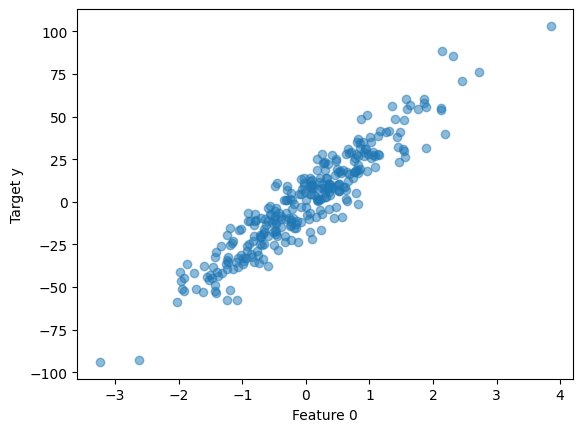

In [3]:
X, y = make_regression(n_samples=300, n_features=1, noise=10.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sort X_test for clean plotting of the prediction line
idx = np.argsort(X_test.ravel())
X_test_sorted = X_test[idx]
y_test_sorted = y_test[idx]

visualize_dataset(X, y, "figs/experiment1/dataset.png")

    Models initialization


[MY_GBM] Loss: L2
  MAE: 8.6462 | MSE: 126.4889 | MedAE: 6.8365 | R2: 0.8775
  Time: 0.0789s


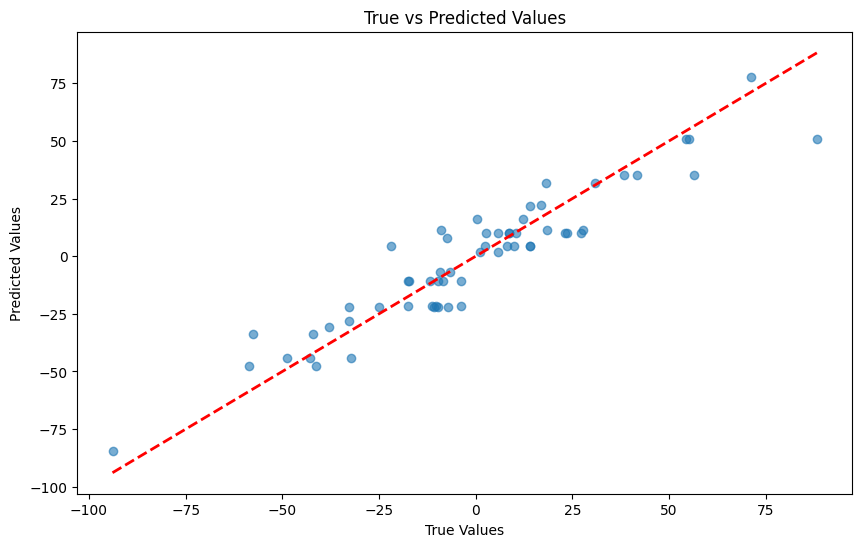


[MY_GBM] Loss: L1
  MAE: 9.0326 | MSE: 153.2348 | MedAE: 6.7973 | R2: 0.8516
  Time: 0.1299s


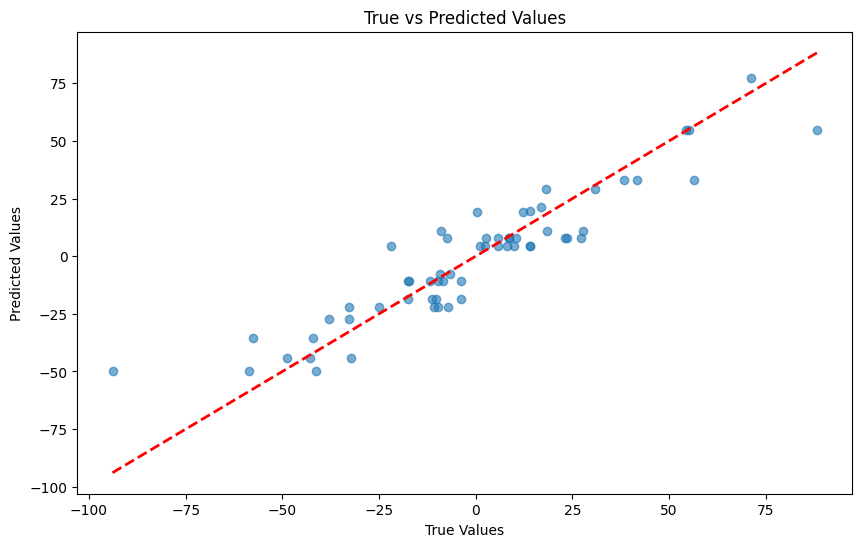


[MY_GBM] Loss: Huber
  MAE: 9.0227 | MSE: 153.4279 | MedAE: 6.7471 | R2: 0.8514
  Time: 0.1102s


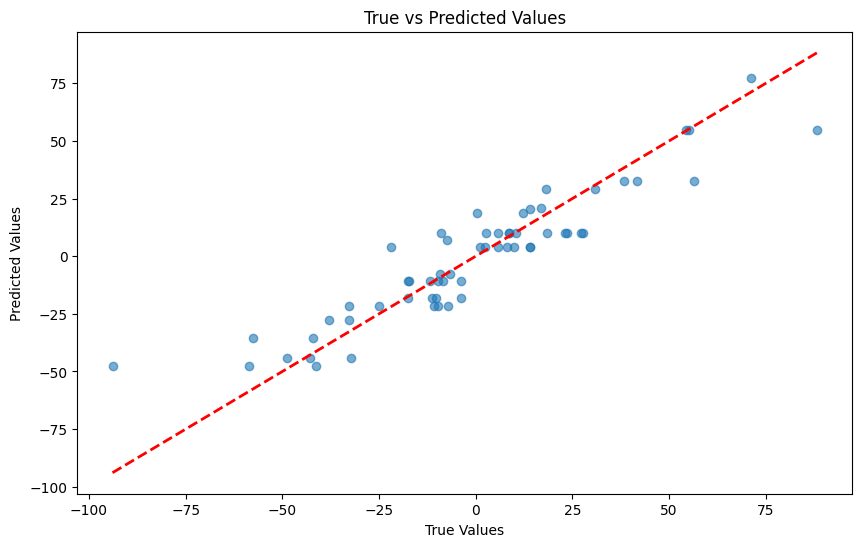


[My_GBM_CUSTOM_TREE] Loss: L2
  MAE: 8.4377 | MSE: 122.2514 | MedAE: 6.8365 | R2: 0.8816
  Time: 1.4848s


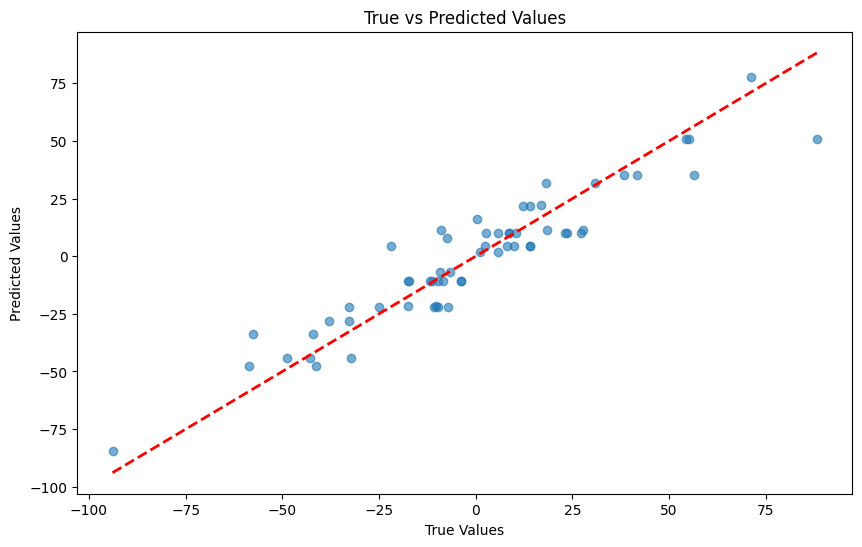


[My_GBM_CUSTOM_TREE] Loss: L1
  MAE: 8.7890 | MSE: 149.5209 | MedAE: 6.6070 | R2: 0.8552
  Time: 1.4226s


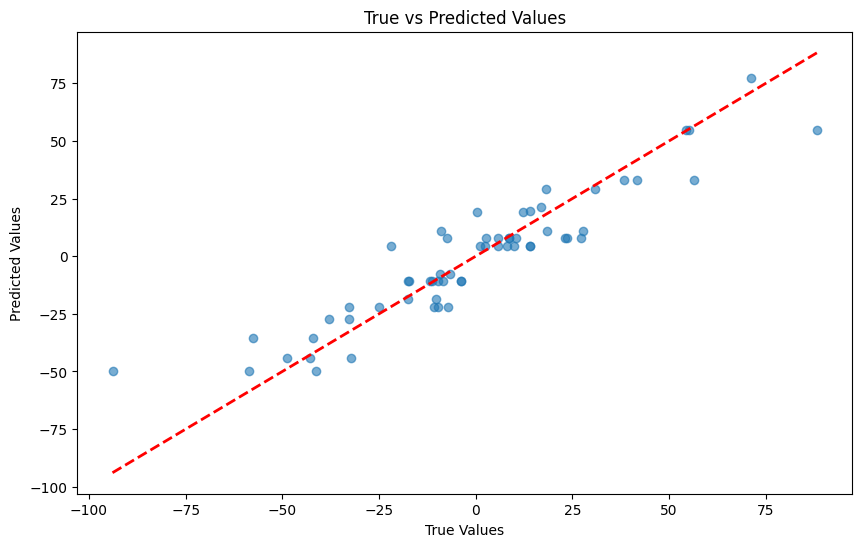


[My_GBM_CUSTOM_TREE] Loss: Huber
  MAE: 8.7945 | MSE: 150.0094 | MedAE: 6.6545 | R2: 0.8548
  Time: 1.4391s


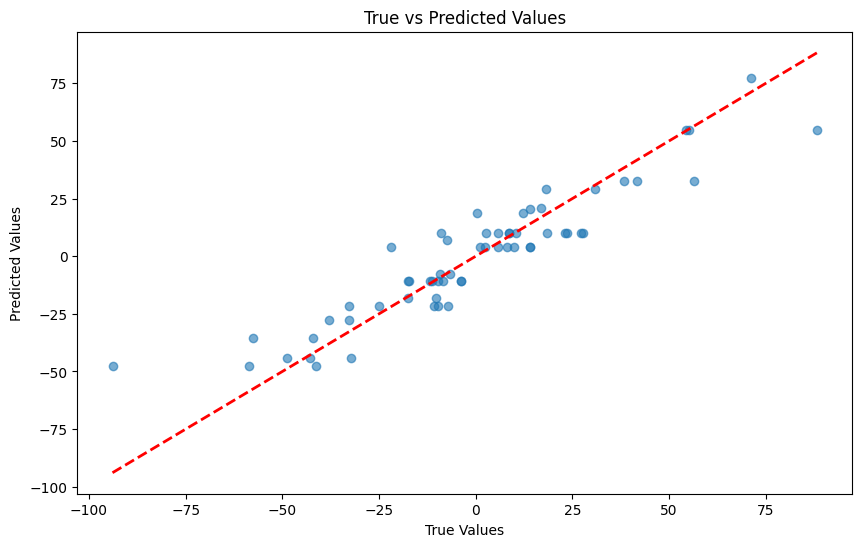


[SKLEARN_GBM_SKLEARN_TREE] Loss: L2
  MAE: 8.6462 | MSE: 126.4889 | MedAE: 6.8365 | R2: 0.8775
  Time: 0.0501s


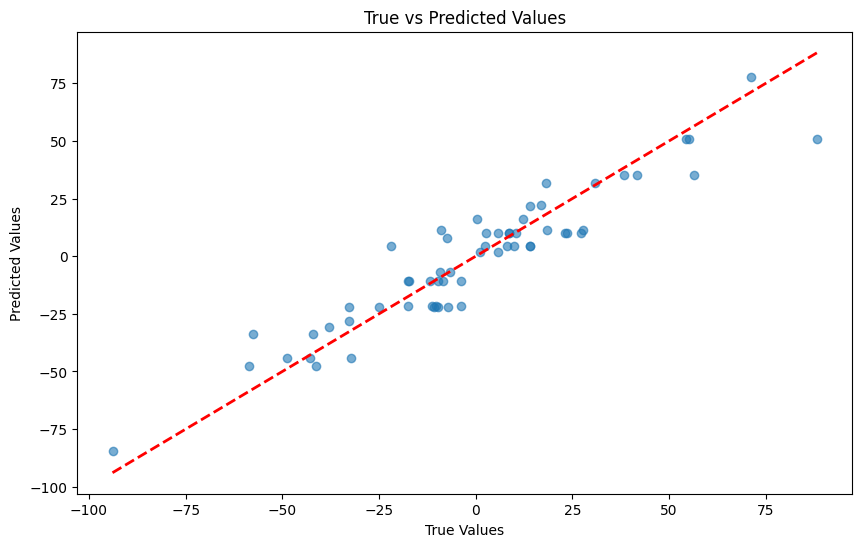


[SKLEARN_GBM_SKLEARN_TREE] Loss: L1
  MAE: 9.0086 | MSE: 152.8026 | MedAE: 6.8921 | R2: 0.8520
  Time: 0.1207s


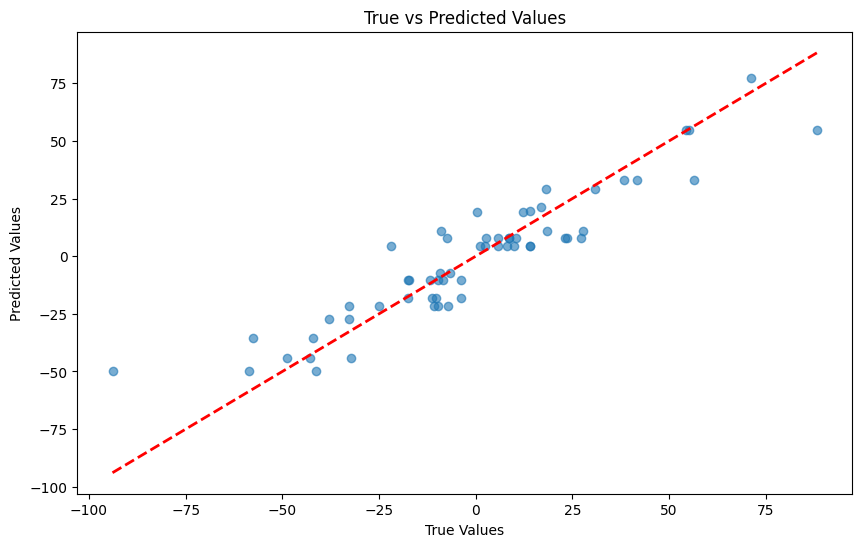


[SKLEARN_GBM_SKLEARN_TREE] Loss: Huber
  MAE: 8.7623 | MSE: 129.1431 | MedAE: 6.9663 | R2: 0.8750
  Time: 0.1478s


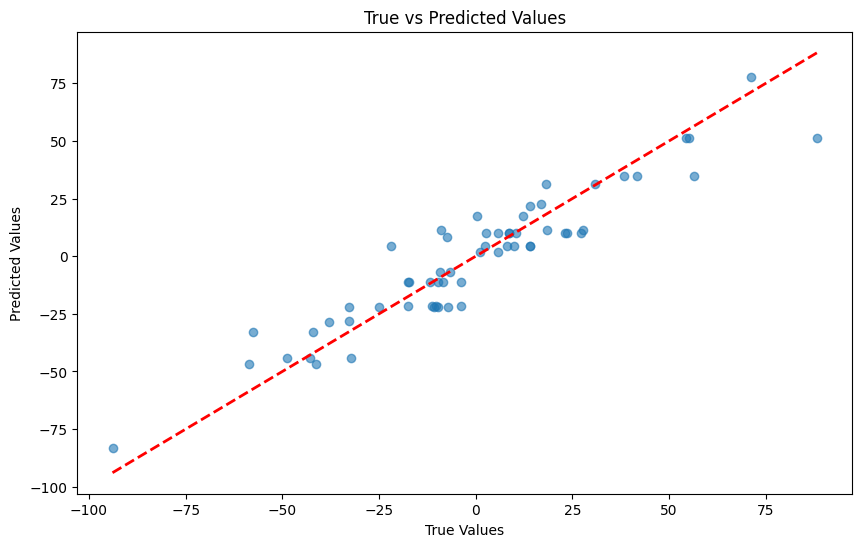

{'model_type': 'SKLEARN_GBM_SKLEARN_TREE',
 'loss_name': 'L2',
 'mae': 8.646153935704655,
 'mse': 126.48888264322353,
 'r2': 0.8775260129513961,
 'depth': 1}

In [ ]:
# my gradient boosting models
models = {
            "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, max_depth=1),
            "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, max_depth=1),
            "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, max_depth=1)
        }

# my gradient boosting models with custom decision tree
models_w_custom_tree = {
            "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, decision_stump_type=MyDecisionTree, max_depth=1),
            "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, decision_stump_type=MyDecisionTree, max_depth=1),
            "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, decision_stump_type=MyDecisionTree, max_depth=1)
        }

# sklearn gradient boosting models
models_w_sklearn = {
            "L2": GradientBoostingRegressor(loss='squared_error', n_estimators=100, max_depth=1),
            "L1": GradientBoostingRegressor(loss='absolute_error', n_estimators=100, max_depth=1),
            "Huber": GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, max_depth=1)
        }   


models_fit_and_prediction(models, X_train, X_test_sorted, y_train, y_test_sorted, 
                          visualize_dataset=True, model_type=ModelType.MY_GBM, fig_path_prefix="figs/experiment1/")

models_fit_and_prediction(models_w_custom_tree, X_train, X_test_sorted, y_train, y_test_sorted,
                            visualize_dataset=True, model_type=ModelType.My_GBM_CUSTOM_TREE, fig_path_prefix="figs/experiment1/")

models_fit_and_prediction(models_w_sklearn, X_train, X_test_sorted, y_train, y_test_sorted,
                            visualize_dataset=True, model_type=ModelType.SKLEARN_GBM_SKLEARN_TREE, fig_path_prefix="figs/experiment1/")


The important conclusion from Experiment 1 is the successful functional verification of the custom Gradient Boosting framework, evidenced by the fact that the custom implementation achieved results identical to the Scikit-Learn industry standard. While the metrics prove mathematical correctness across all loss functions, a significant performance trade-off was observed: the custom `MyDecisionTree` reached a slightly higher $R^2$ score (0.8816) compared to the Sklearn-based models (0.8775), yet required nearly 30 times more computation time due to the overhead of pure Python execution. This confirms that while your implementation is accurate and flexible enough to outperform standard splits on specific datasets, the transition from optimized C-code to Python results in a substantial loss of efficiency, highlighting the importance of algorithmic optimization in large-scale ensemble methods.

### Experiment 2

The scope of this experiment is to evaluate the scalability of the custom GBRegressor when moving to a high-dimensional dataset. By increasing the input space to 10 features, we test the algorithm's ability to perform feature selection and find optimal split points across multiple variables. This experiment want to confirm that the gradient descent logic and the "best split" search in MyDecisionTree remain numerically stable and computationally feasible as the complexity of the regression increases.

    Generate Synthetic Data

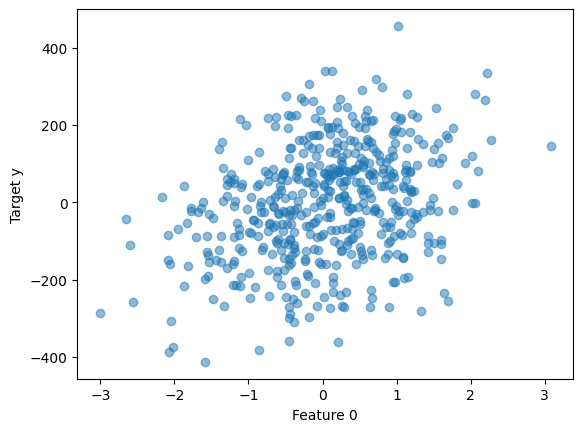

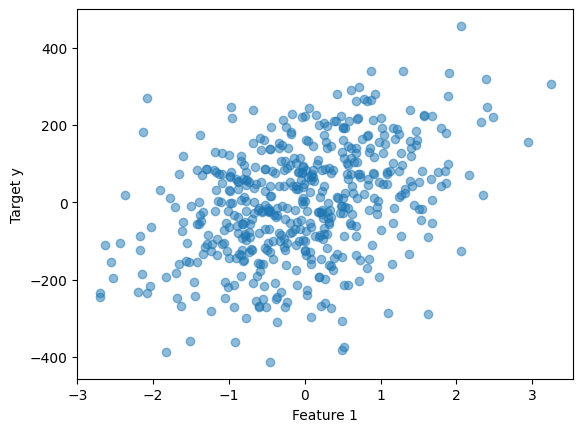

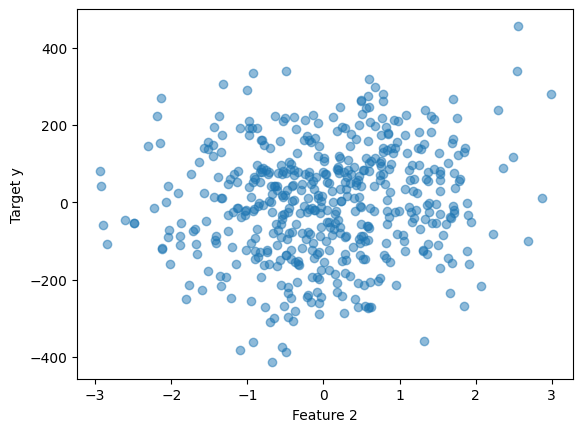

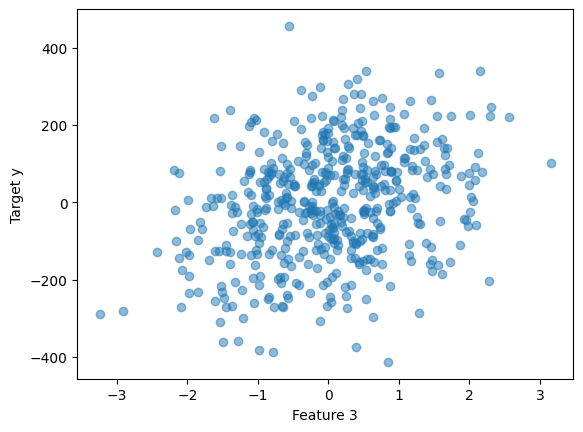

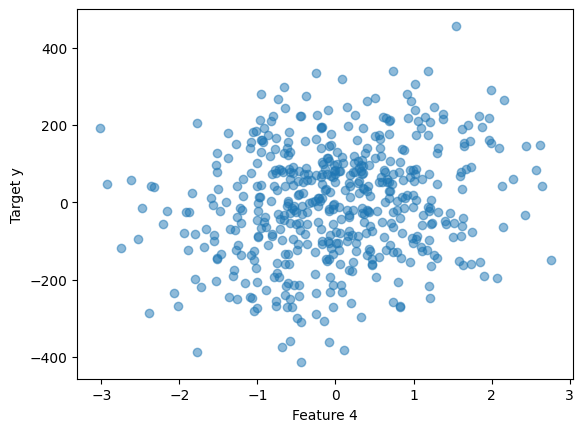

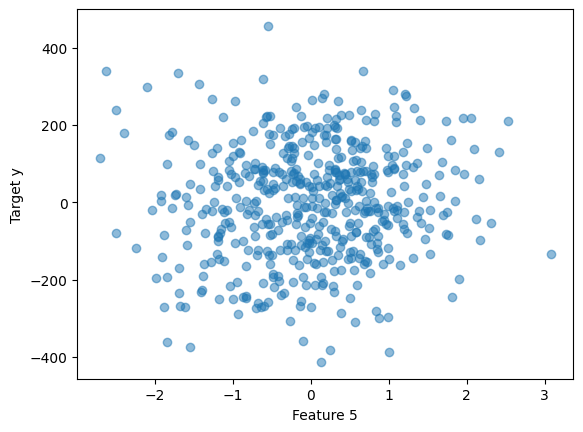

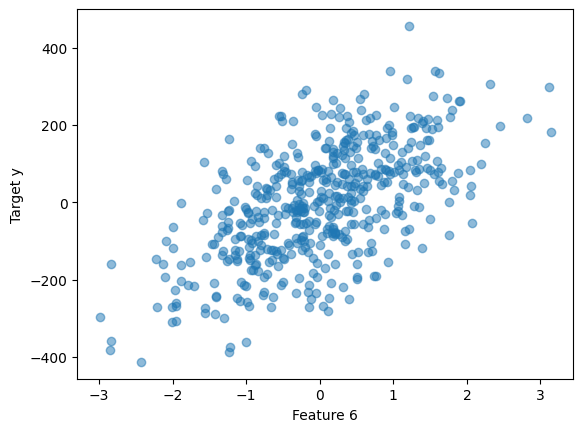

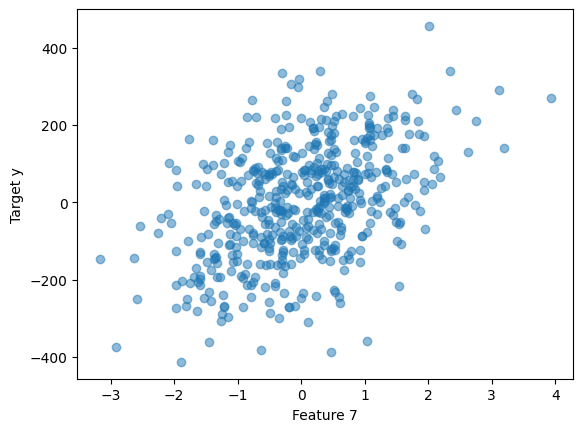

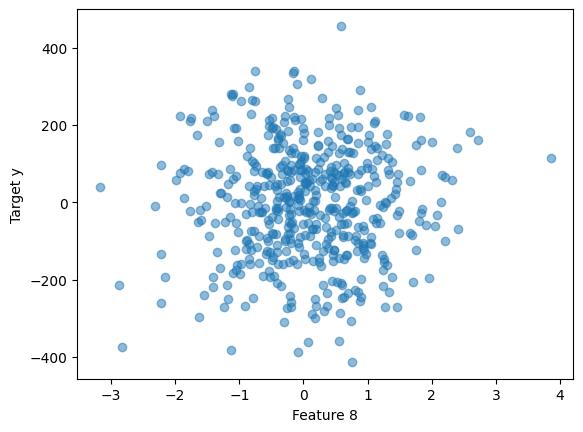

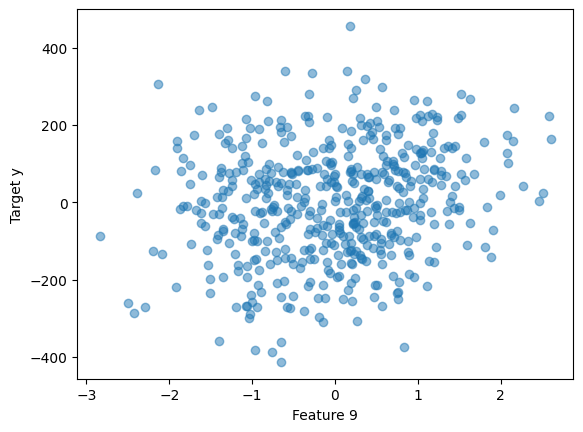

In [5]:
X, y = make_regression(n_samples=500, n_features=10, noise=10.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

visualize_dataset(X, y, "figs/experiment2/dataset.png")


[MY_GBM] Loss: L2
  MAE: 39.7128 | MSE: 2533.6993 | MedAE: 33.9161 | R2: 0.8714
  Time: 0.3709s


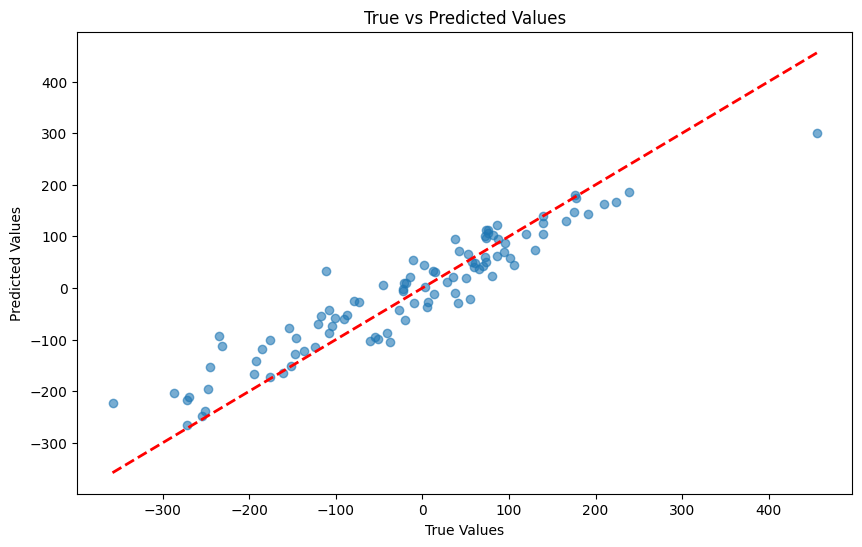


[MY_GBM] Loss: L1
  MAE: 44.0892 | MSE: 3664.2530 | MedAE: 32.4011 | R2: 0.8140
  Time: 0.5053s


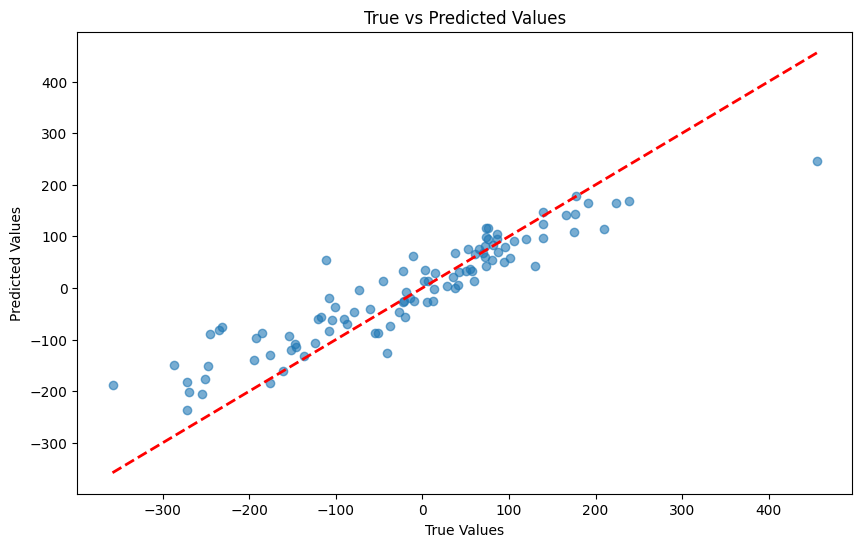


[MY_GBM] Loss: Huber
  MAE: 45.2380 | MSE: 3744.6860 | MedAE: 36.1605 | R2: 0.8099
  Time: 0.4422s


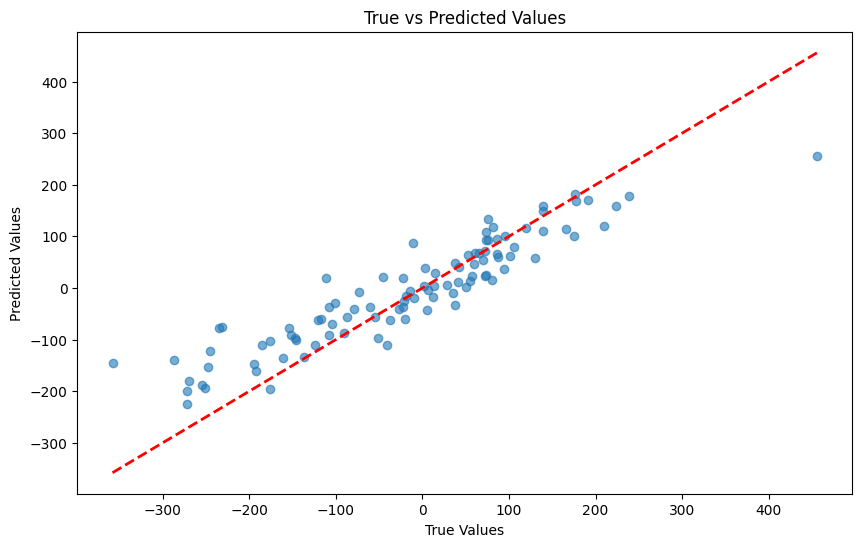


[My_GBM_CUSTOM_TREE] Loss: L2
  MAE: 39.9623 | MSE: 2553.2595 | MedAE: 34.1818 | R2: 0.8704
  Time: 0.4156s


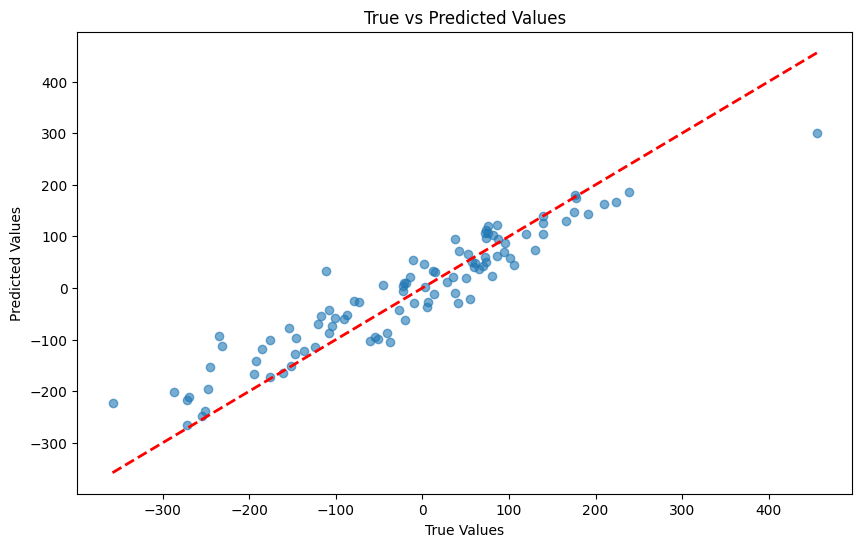


[My_GBM_CUSTOM_TREE] Loss: L1
  MAE: 44.2803 | MSE: 3756.3327 | MedAE: 29.4897 | R2: 0.8093
  Time: 0.4495s


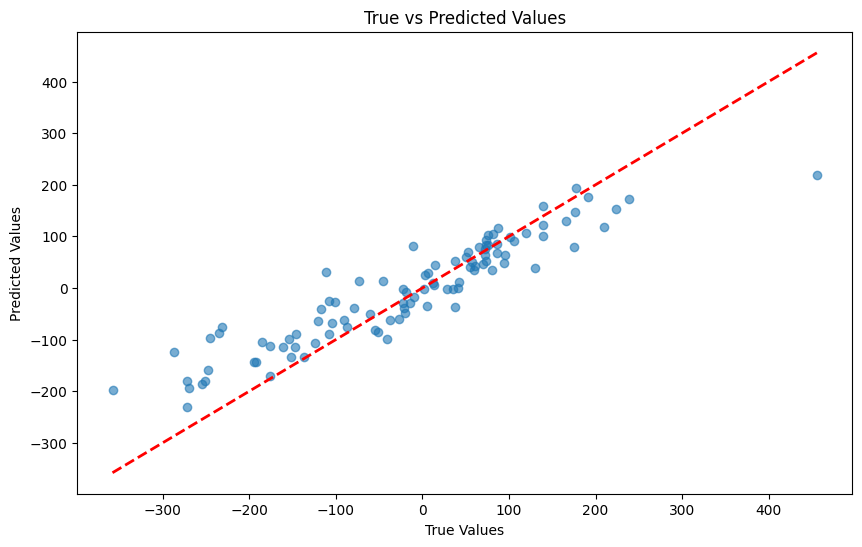


[My_GBM_CUSTOM_TREE] Loss: Huber
  MAE: 43.3205 | MSE: 3513.3675 | MedAE: 31.8716 | R2: 0.8216
  Time: 0.4412s


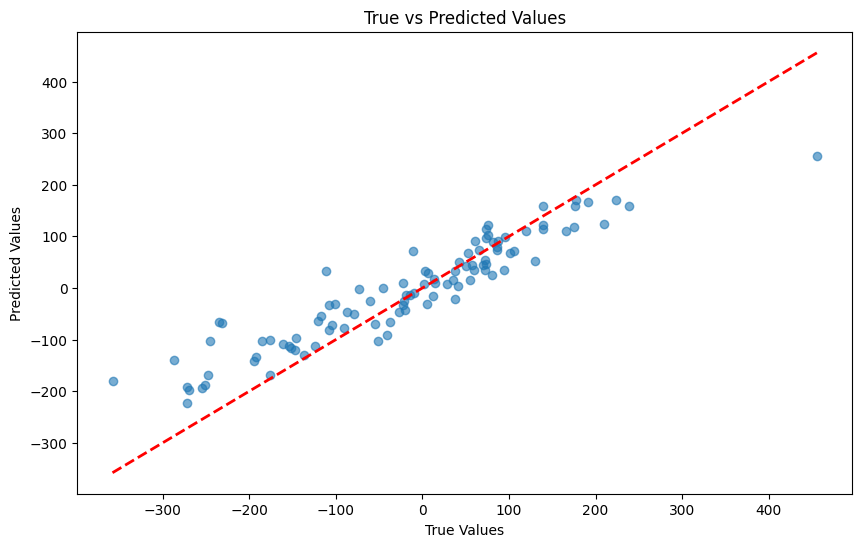


[SKLEARN_GBM_SKLEARN_TREE] Loss: L2
  MAE: 39.7423 | MSE: 2533.7301 | MedAE: 33.9161 | R2: 0.8714
  Time: 0.4134s


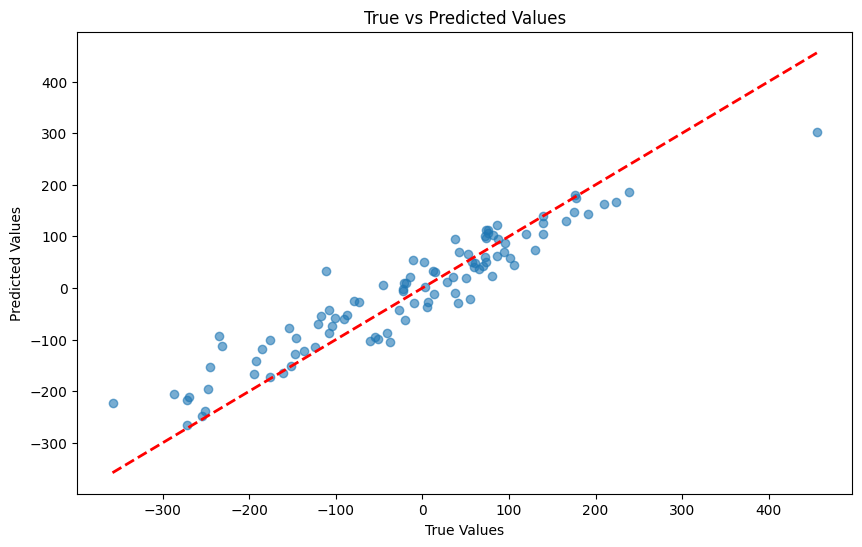


[SKLEARN_GBM_SKLEARN_TREE] Loss: L1
  MAE: 43.6200 | MSE: 3668.2672 | MedAE: 34.8686 | R2: 0.8138
  Time: 0.6134s


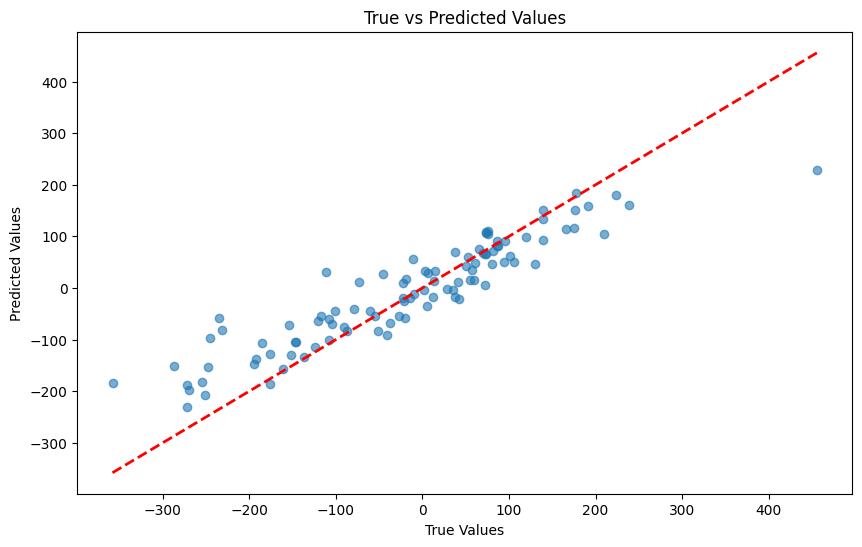


[SKLEARN_GBM_SKLEARN_TREE] Loss: Huber
  MAE: 39.8175 | MSE: 2548.0202 | MedAE: 32.6252 | R2: 0.8706
  Time: 0.6568s


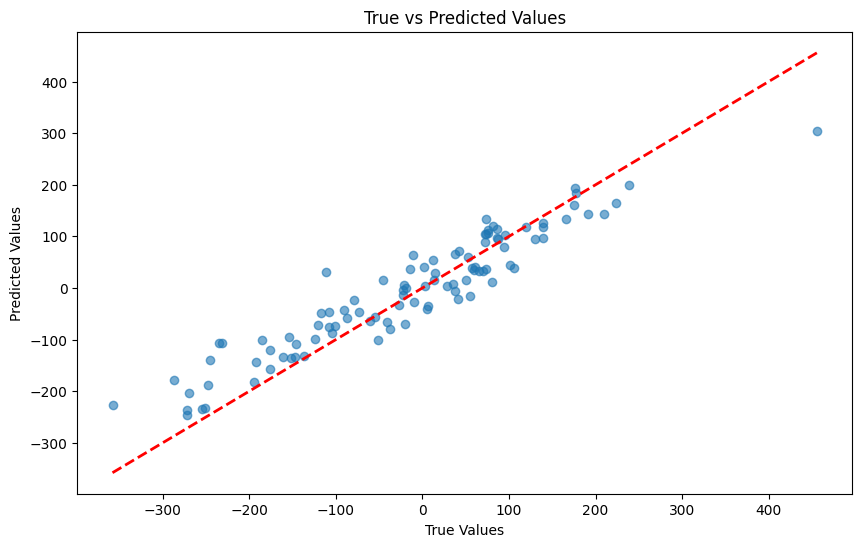

{'model_type': 'SKLEARN_GBM_SKLEARN_TREE',
 'loss_name': 'L2',
 'mae': 39.74232316593144,
 'mse': 2533.7301410593363,
 'r2': 0.8713712798925956,
 'depth': 3}

In [6]:
# my gradient boosting models
models = {
    "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, max_depth=3),
    "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, max_depth=3),
    "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, max_depth=3)
}

models_fit_and_prediction(models, X_train, X_test, y_train, y_test, 
                          visualize_dataset=True, model_type=ModelType.MY_GBM, fig_path_prefix="figs/experiment2/")

# my gradient boosting models with custom decision tree 
models_w_custom_tree = {
    "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, max_depth=3),
    "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, max_depth=3),
    "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, max_depth=3)
}

models_fit_and_prediction(models_w_custom_tree, X_train, X_test, y_train, y_test,
                            visualize_dataset=True, model_type=ModelType.My_GBM_CUSTOM_TREE, fig_path_prefix="figs/experiment2/")

# sklearn gradient boosting models
models_w_sklearn = {
    "L2": GradientBoostingRegressor(loss='squared_error', n_estimators=100, max_depth=3),
    "L1": GradientBoostingRegressor(loss='absolute_error', n_estimators=100, max_depth=3),
    "Huber": GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, max_depth=3)
}
models_fit_and_prediction(models_w_sklearn, X_train, X_test, y_train, y_test, 
                          visualize_dataset=True, model_type=ModelType.SKLEARN_GBM_SKLEARN_TREE, fig_path_prefix="figs/experiment2/")

The results demonstrate that the model successfully adapts to higher dimensions. The custom implementation produces MAE and MSE metrics nearly identical to the Scikit-Learn baseline, proving that the multi-feature gradient calculations are mathematically correct.

### Experiment 3

The objective of this experiment is to test the different loss functions by introducing artificial noise and outliers into the dataset. While previous experiments used "clean" synthetic data, real-world data is often corrupted by measurement errors or extreme values.

    Generate Synthetic Data

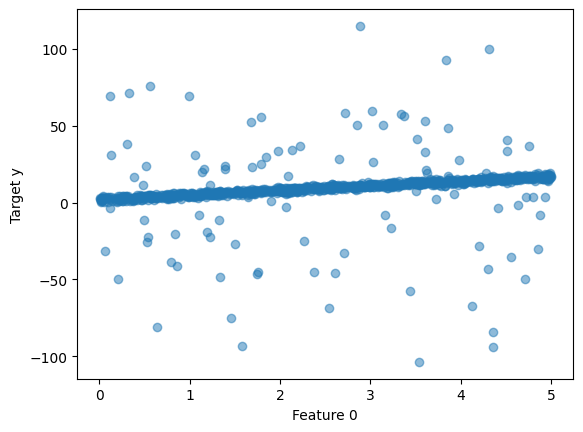

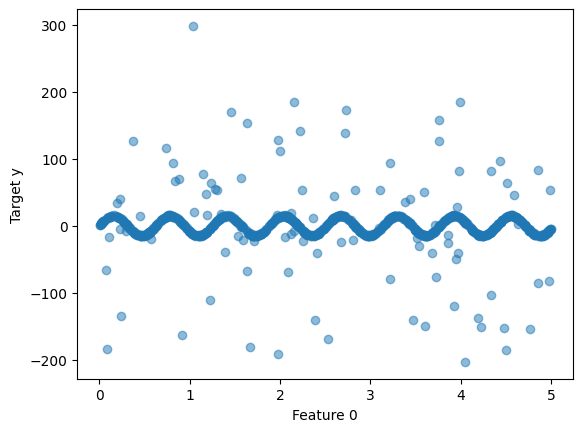

In [9]:
n_samples = 1000
X = np.sort(5 * np.random.rand(n_samples, 1), axis=0)

# Dataset Clean Linear
y_linear = 3 * X.squeeze() + 2 + np.random.normal(0, 1, n_samples)

# Dataset Clean Non-Linear 
y_nonlinear = np.sin(X.squeeze() * 10) *15 + np.random.normal(0, 0.5, n_samples)

datasets = {
    "Linear": (X, inject_outliers(y_linear)),
    "Non-Linear": (X, inject_outliers(y_nonlinear))
}

for dataset_name, (X, y) in datasets.items():
    visualize_dataset(X, y, f"figs/experiment3/{dataset_name}_dataset.png")


    Model initialization


[MY_GBM] Loss: L2
  MAE: 4.9708 | MSE: 198.7629 | MedAE: 1.5845 | R2: 0.0287
  Time: 0.0955s


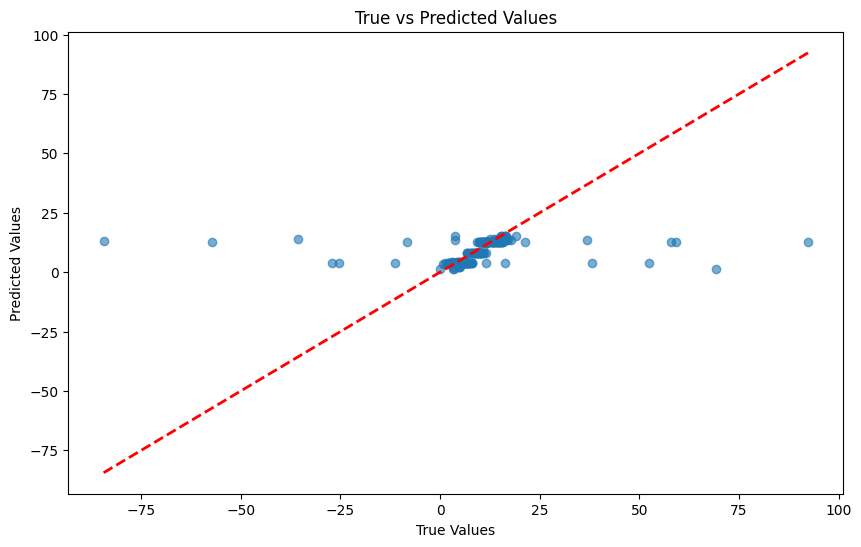


[MY_GBM] Loss: L1
  MAE: 4.3147 | MSE: 198.2122 | MedAE: 0.7284 | R2: 0.0314
  Time: 0.1224s


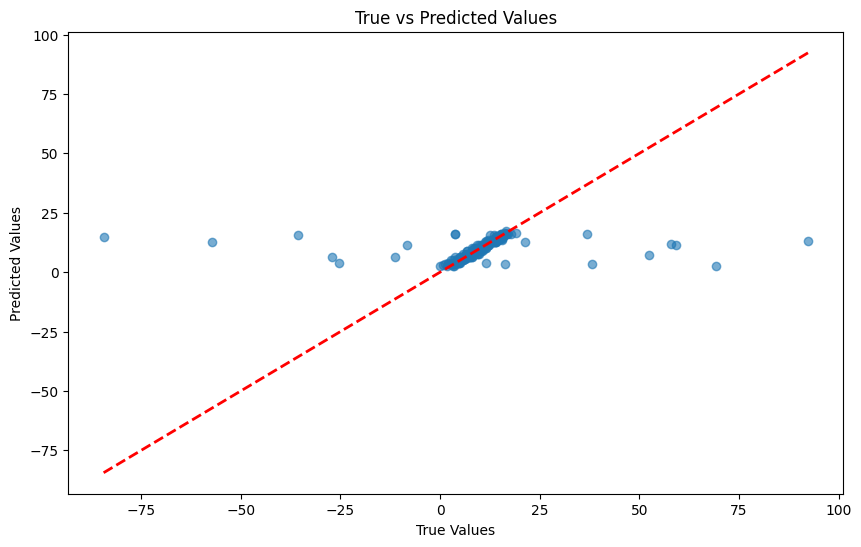


[MY_GBM] Loss: Huber
  MAE: 4.2990 | MSE: 198.5731 | MedAE: 0.7409 | R2: 0.0297
  Time: 0.1211s


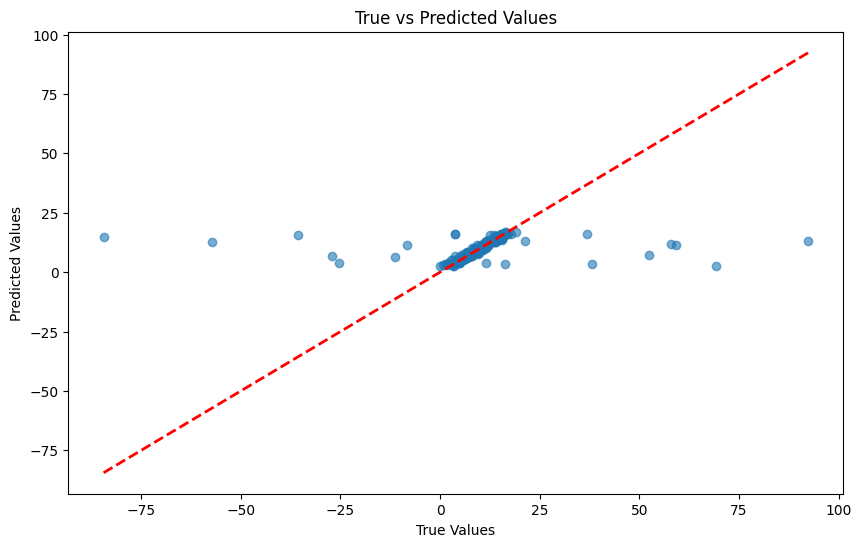


[My_GBM_CUSTOM_TREE] Loss: L2
  MAE: 4.9708 | MSE: 198.7629 | MedAE: 1.5845 | R2: 0.0287
  Time: 5.1863s


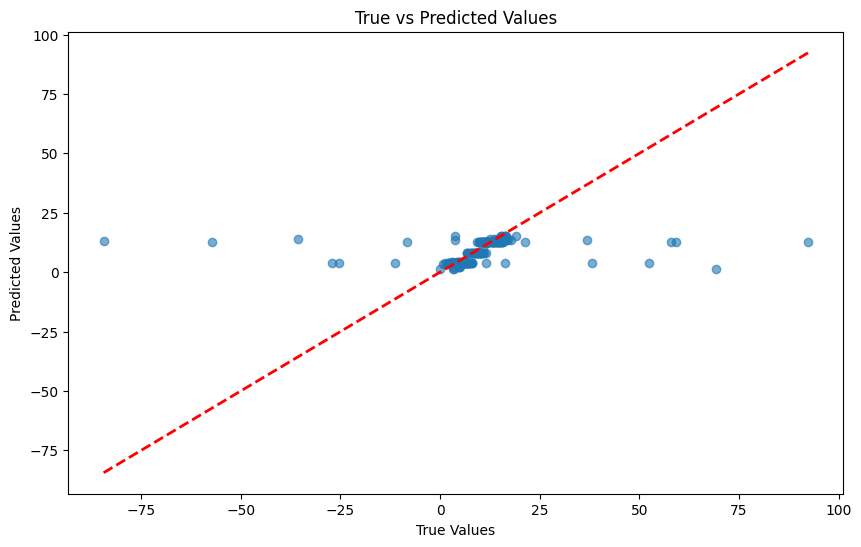


[My_GBM_CUSTOM_TREE] Loss: L1
  MAE: 4.3150 | MSE: 198.2025 | MedAE: 0.7538 | R2: 0.0315
  Time: 5.0429s


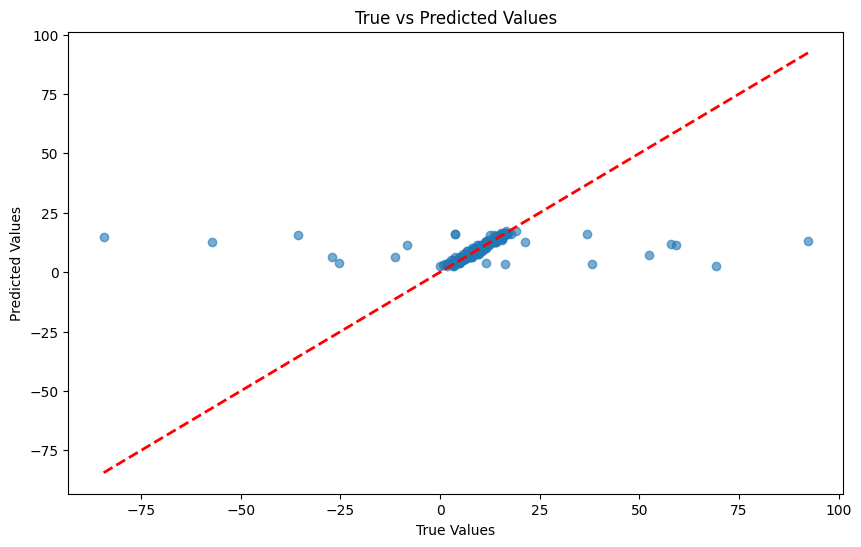


[My_GBM_CUSTOM_TREE] Loss: Huber
  MAE: 4.3014 | MSE: 198.5752 | MedAE: 0.7537 | R2: 0.0297
  Time: 5.2515s


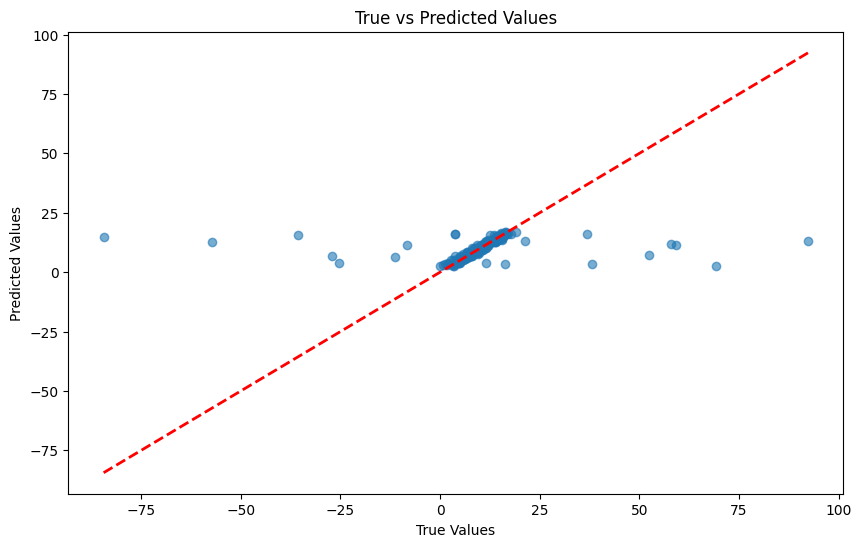


[SKLEARN_GBM_SKLEARN_TREE] Loss: L2
  MAE: 4.9708 | MSE: 198.7629 | MedAE: 1.5845 | R2: 0.0287
  Time: 0.0801s


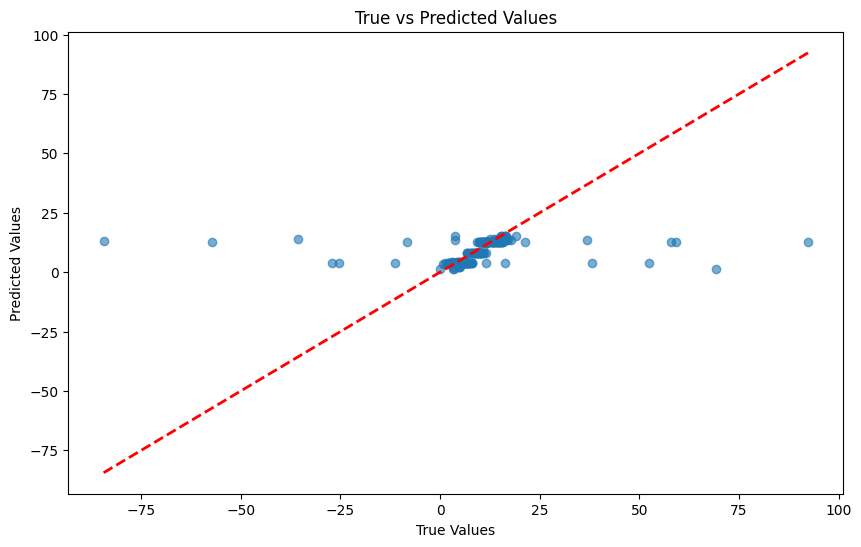


[SKLEARN_GBM_SKLEARN_TREE] Loss: L1
  MAE: 4.3120 | MSE: 198.1976 | MedAE: 0.7292 | R2: 0.0315
  Time: 0.1346s


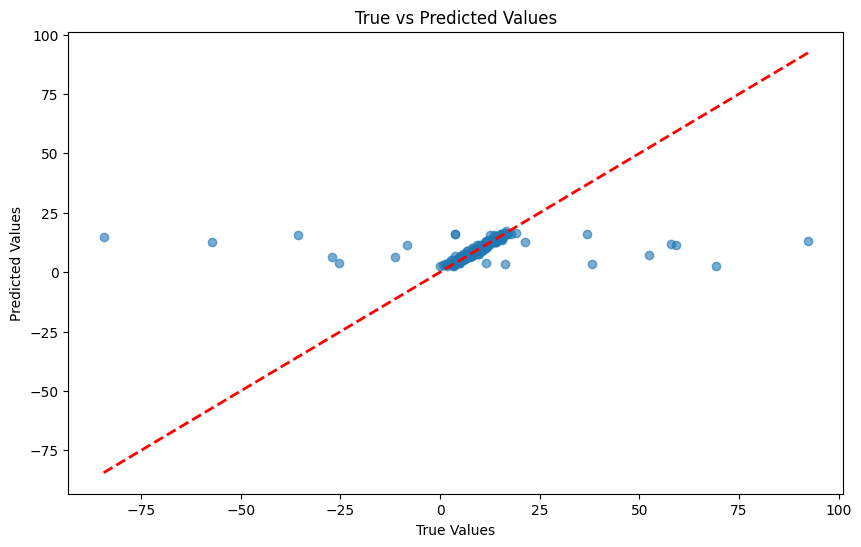


[SKLEARN_GBM_SKLEARN_TREE] Loss: Huber
  MAE: 4.3232 | MSE: 198.8830 | MedAE: 0.7852 | R2: 0.0282
  Time: 0.1718s


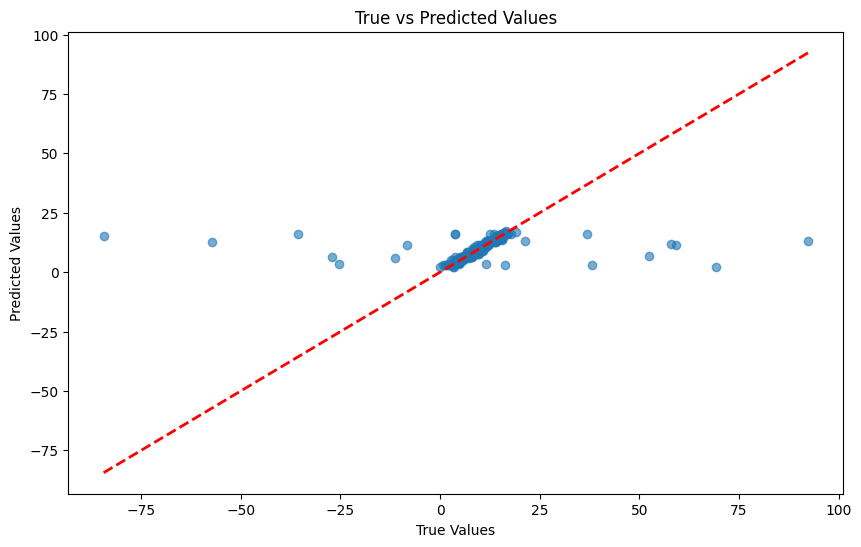


[MY_GBM] Loss: L2
  MAE: 13.5030 | MSE: 844.0024 | MedAE: 8.4084 | R2: -0.0137
  Time: 0.0881s


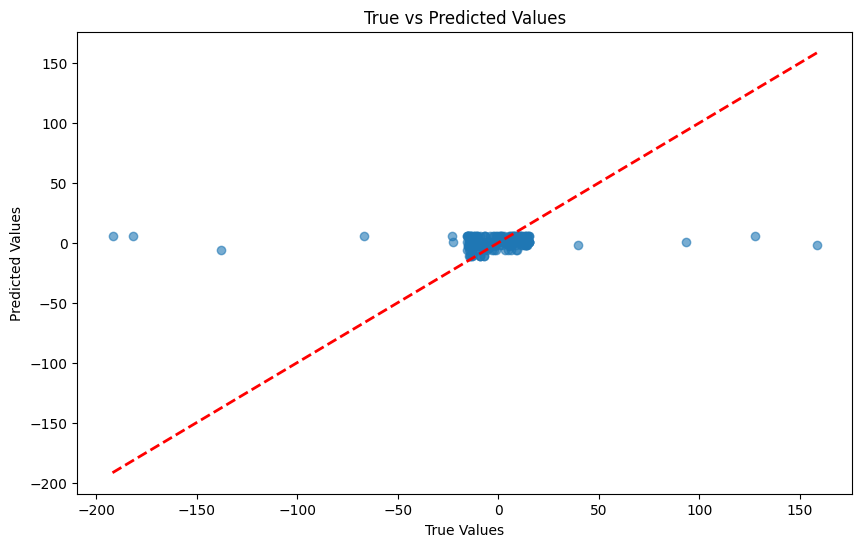


[MY_GBM] Loss: L1
  MAE: 13.1149 | MSE: 820.3167 | MedAE: 8.5914 | R2: 0.0148
  Time: 0.1277s


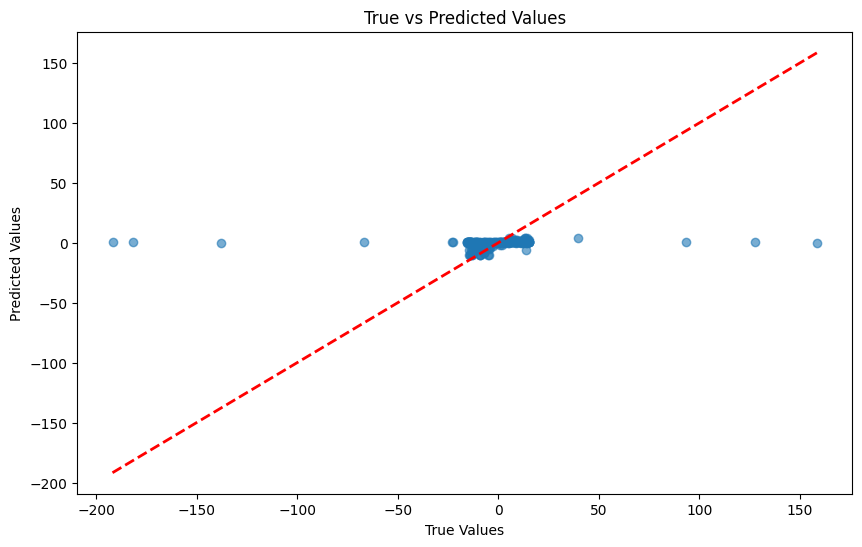


[MY_GBM] Loss: Huber
  MAE: 13.1224 | MSE: 819.8370 | MedAE: 8.8037 | R2: 0.0153
  Time: 0.1286s


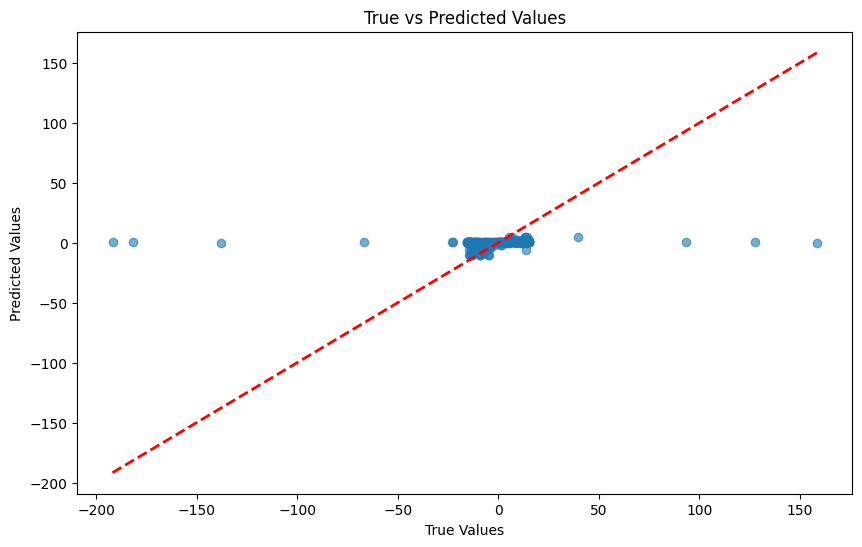


[My_GBM_CUSTOM_TREE] Loss: L2
  MAE: 13.4830 | MSE: 843.9427 | MedAE: 8.4084 | R2: -0.0136
  Time: 5.1183s


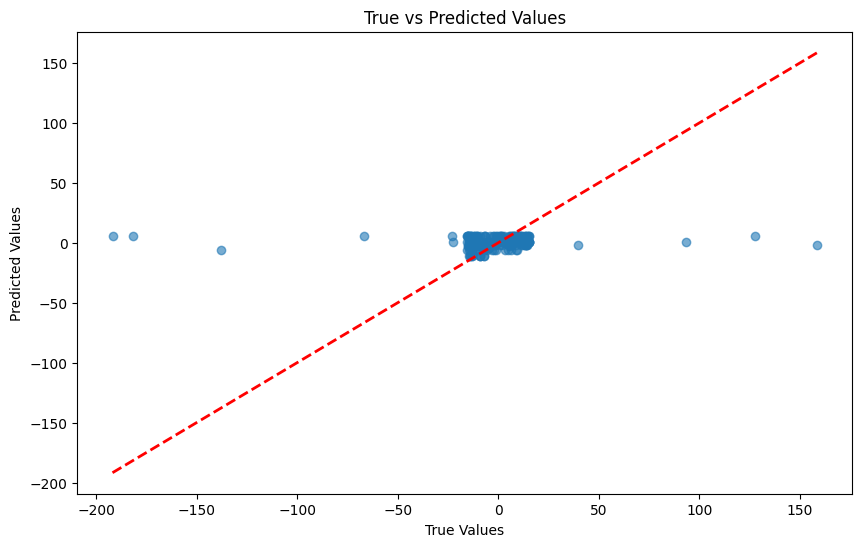


[My_GBM_CUSTOM_TREE] Loss: L1
  MAE: 13.1214 | MSE: 820.3352 | MedAE: 8.5914 | R2: 0.0148
  Time: 5.0763s


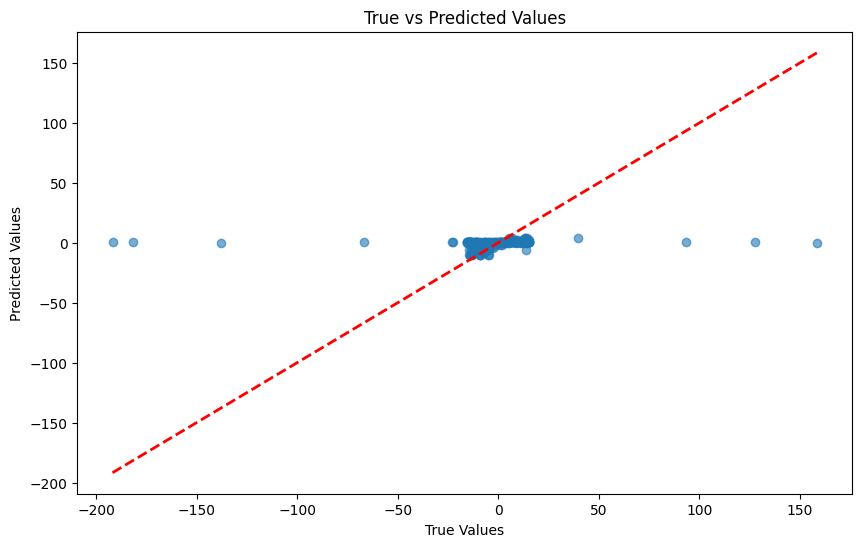


[My_GBM_CUSTOM_TREE] Loss: Huber
  MAE: 13.1289 | MSE: 819.8516 | MedAE: 8.8037 | R2: 0.0153
  Time: 5.0574s


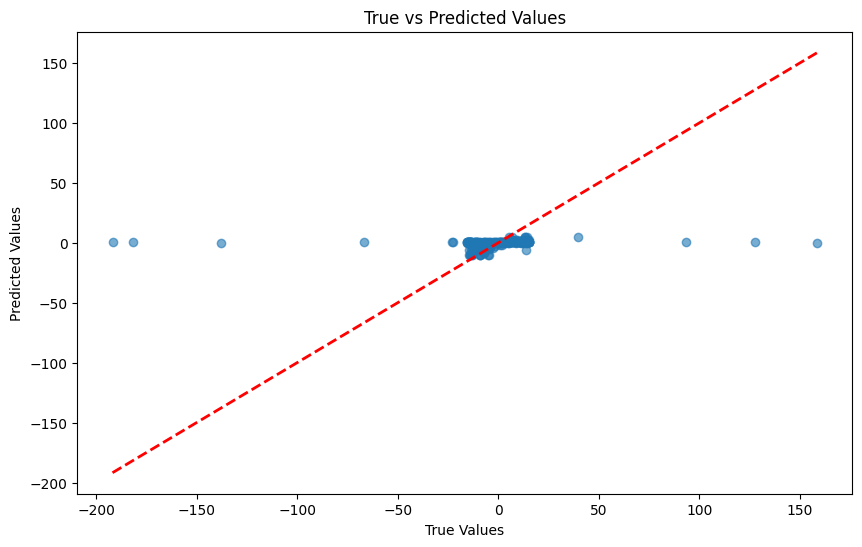


[SKLEARN_GBM_SKLEARN_TREE] Loss: L2
  MAE: 13.5030 | MSE: 844.0024 | MedAE: 8.4084 | R2: -0.0137
  Time: 0.0707s


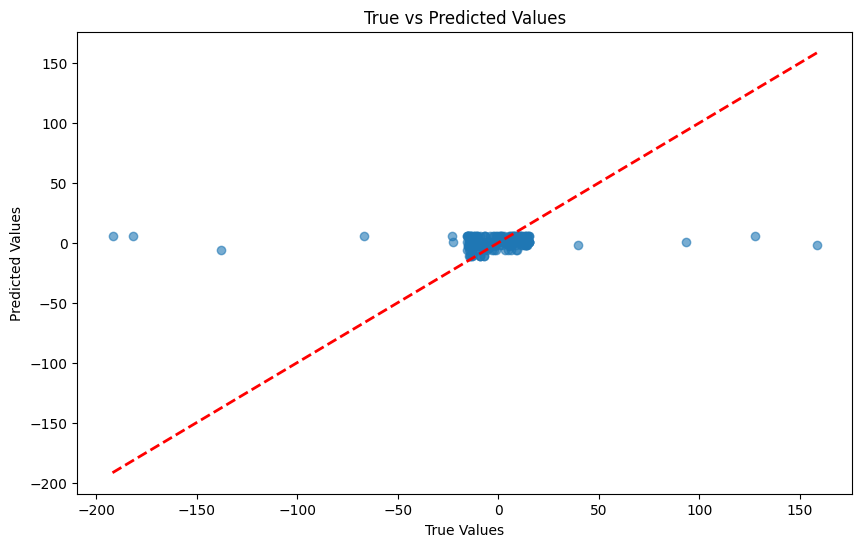


[SKLEARN_GBM_SKLEARN_TREE] Loss: L1
  MAE: 13.1199 | MSE: 820.5290 | MedAE: 8.6331 | R2: 0.0145
  Time: 0.1461s


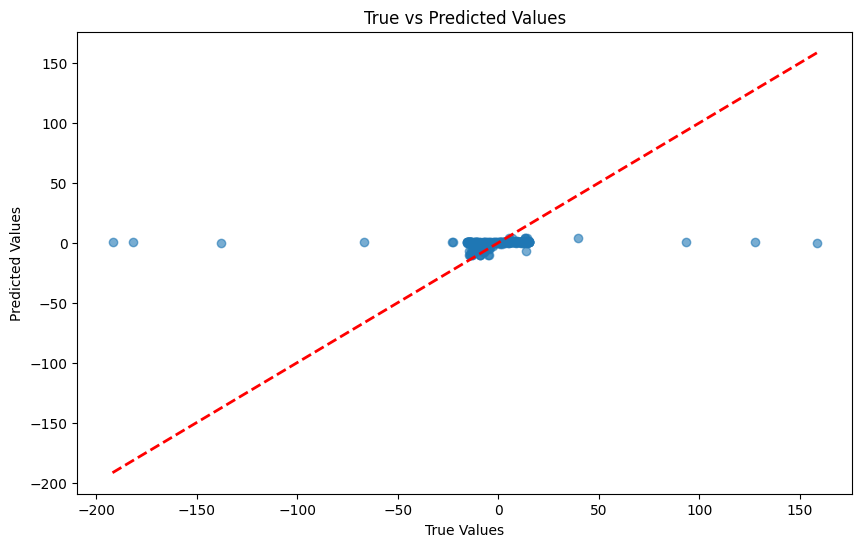


[SKLEARN_GBM_SKLEARN_TREE] Loss: Huber
  MAE: 13.0554 | MSE: 818.5212 | MedAE: 8.5084 | R2: 0.0169
  Time: 0.1855s


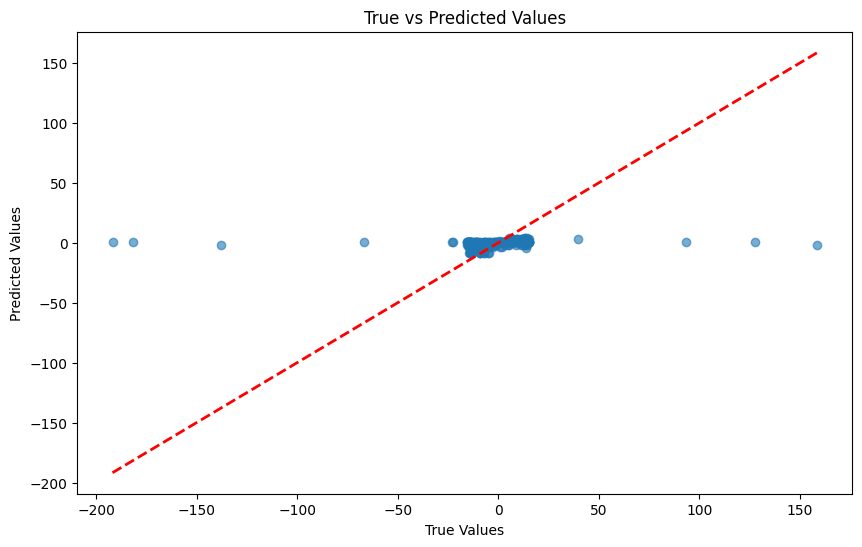

In [10]:
for dataset_name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # my gradient boosting models
    models = {
        "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, max_depth=1),
        "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, max_depth=1),
        "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, max_depth=1)
    }

    models_fit_and_prediction(models, X_train, X_test, y_train, y_test, 
                            visualize_dataset=True, model_type=ModelType.MY_GBM, fig_path_prefix=f"figs/experiment3/{dataset_name}_")

    # my gradient boosting models with custom decision tree
    models_w_custom_tree = {
        "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, decision_stump_type=MyDecisionTree, max_depth=1),
        "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, decision_stump_type=MyDecisionTree, max_depth=1),
        "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, decision_stump_type=MyDecisionTree, max_depth=1)
    }

    models_fit_and_prediction(models_w_custom_tree, X_train, X_test, y_train, y_test,
                                visualize_dataset=True, model_type=ModelType.My_GBM_CUSTOM_TREE, fig_path_prefix=f"figs/experiment3/{dataset_name}_")

    # sklearn gradient boosting models
    models_w_sklearn = {
        "L2": GradientBoostingRegressor(loss='squared_error', n_estimators=100, max_depth=1),
        "L1": GradientBoostingRegressor(loss='absolute_error', n_estimators=100, max_depth=1),
        "Huber": GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, max_depth=1)
    }

    models_fit_and_prediction(models_w_sklearn, X_train, X_test, y_train, y_test,
                                visualize_dataset=True, model_type=ModelType.SKLEARN_GBM_SKLEARN_TREE, fig_path_prefix=f"figs/experiment3/{dataset_name}_")

The results across both datasets reveal that the L2 loss is significantly less robust, as its quadratic penalty forces the regression curve to shift toward the outliers, distorting the linear slope and flattening the non-linear sine wave oscillations. 

In contrast, the L1 loss remains firmly to the dense central trend, demonstrating stability by ignoring the magnitude of extreme errors. 

The Huber loss provides the most versatile performance, it effectively captures the complex curvature of the non-linear sine wave using its quadratic behavior for small residuals.

### Experiment 4

The goal of this experiment is to investigate how the maximum depth of the weak learners influences the overall performance.
This experiment evaluates the trade-off between underfitting (depth 1), where the model may be too simple to capture feature interactions, and overfitting (depth 7+), where individual trees might become too specialized to the training noise, leading to poor generalization.

    Generate Synthetic Data

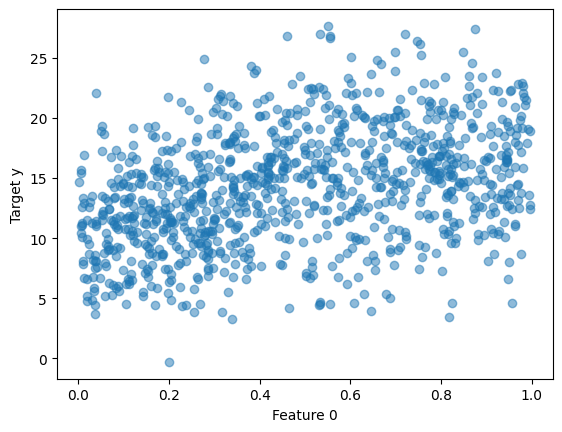

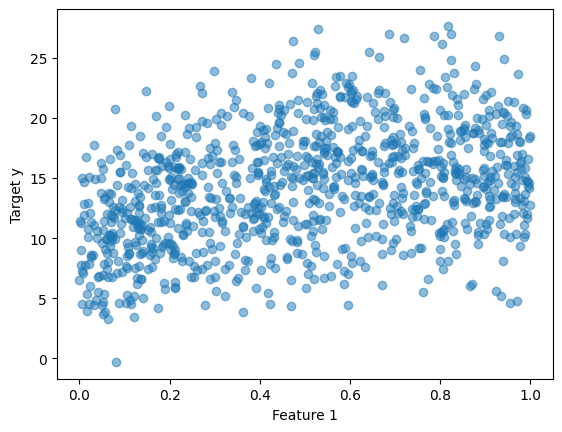

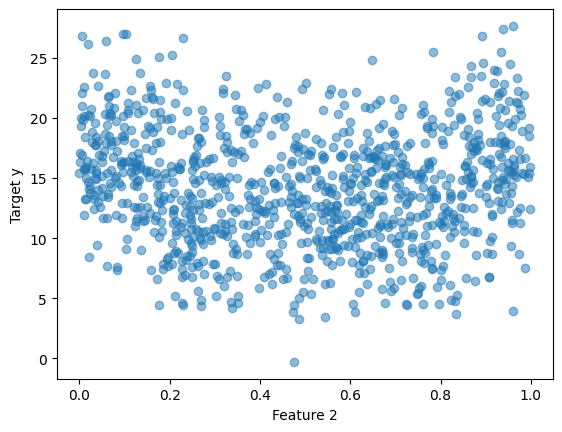

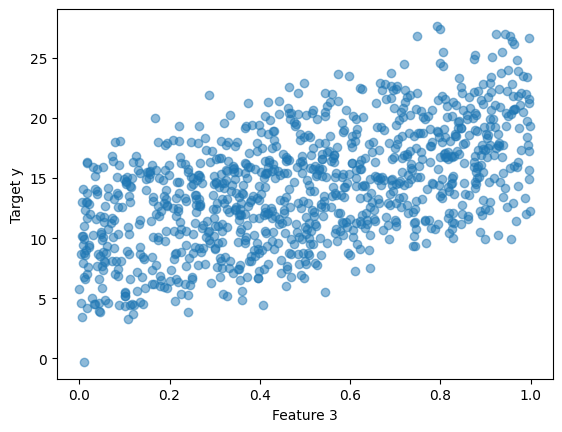

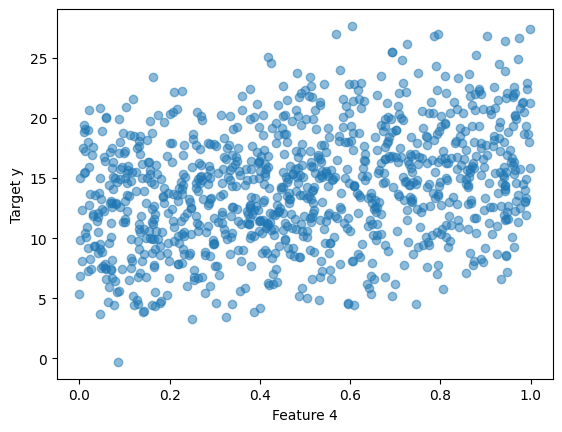

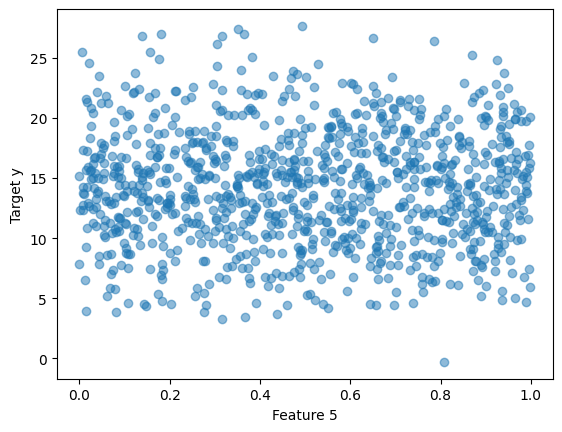

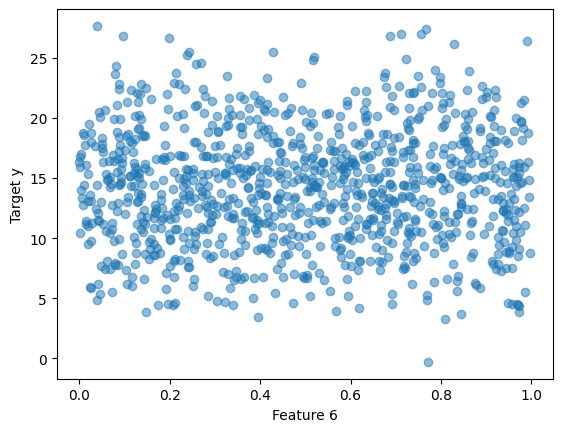

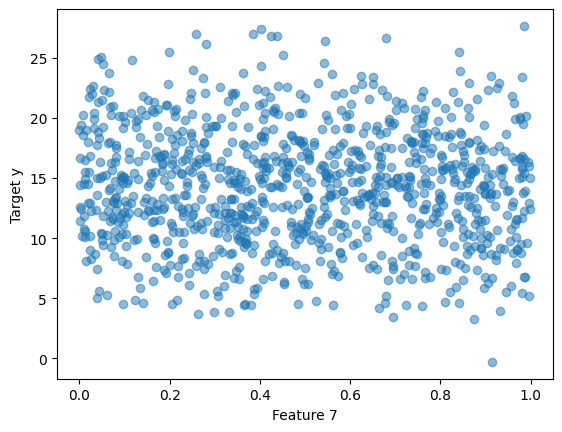

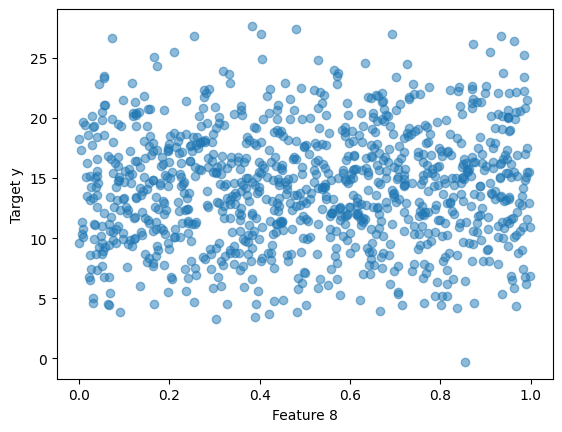

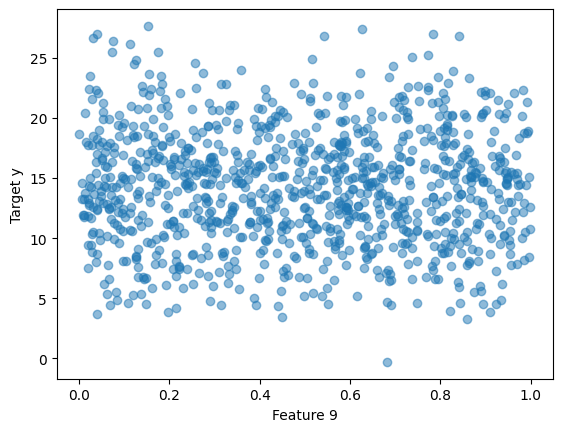

In [11]:
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_friedman1(n_samples=n_samples, n_features=10, noise=1.0, random_state=42)
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

visualize_dataset(X, y, "figs/experiment4/dataset.png")
 
 

    Model initialization

Starting Max Depth vs. Loss Analysis...
Processing Max Depth: 1...
Processing Max Depth: 2...
Processing Max Depth: 3...
Processing Max Depth: 5...
Processing Max Depth: 7...


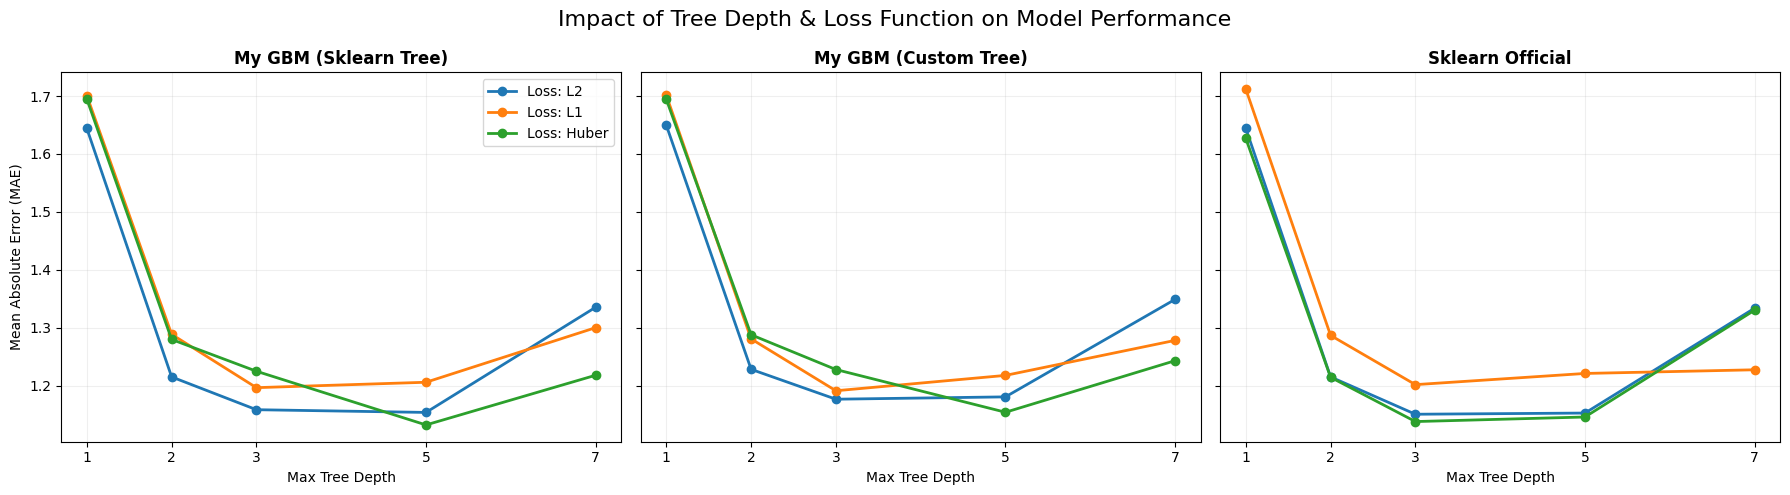

In [12]:

depths = [1, 2, 3, 5, 7]  

history_depth = {
    "My GBM (Sklearn Tree)": {"L2": [], "L1": [], "Huber": []},
    "My GBM (Custom Tree)":  {"L2": [], "L1": [], "Huber": []},
    "Sklearn Official":      {"L2": [], "L1": [], "Huber": []}
}

print("Starting Max Depth vs. Loss Analysis...")

for depth in depths:
    print(f"Processing Max Depth: {depth}...")
        
    # My GBM with Sklearn Tree
    dict_my_gbm = {
        "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, max_depth=depth, learning_rate=0.1),
        "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, max_depth=depth, learning_rate=0.1),
        "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, max_depth=depth, learning_rate=0.1)
    }

    # My GBM with Custom Tree (ADDED decision_stump_type argument)
    dict_custom = {
        "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, max_depth=depth, learning_rate=0.1, decision_stump_type=MyDecisionTree),
        "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, max_depth=depth, learning_rate=0.1, decision_stump_type=MyDecisionTree),
        "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, max_depth=depth, learning_rate=0.1, decision_stump_type=MyDecisionTree)
    }

    # Sklearn GBM
    dict_sklearn = {
        "L2": GradientBoostingRegressor(loss='squared_error', n_estimators=100, max_depth=depth, learning_rate=0.1),
        "L1": GradientBoostingRegressor(loss='absolute_error', n_estimators=100, max_depth=depth, learning_rate=0.1),
        "Huber": GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, max_depth=depth, learning_rate=0.1)
    }

    process_models(dict_my_gbm, "My GBM (Sklearn Tree)", X_train, X_test, y_train, y_test, history_depth)
    process_models(dict_custom, "My GBM (Custom Tree)", X_train, X_test, y_train, y_test, history_depth)
    process_models(dict_sklearn, "Sklearn Official", X_train, X_test, y_train, y_test, history_depth)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

implementation_names = [
    "My GBM (Sklearn Tree)", 
    "My GBM (Custom Tree)", 
    "Sklearn Official"
]

for idx, impl_name in enumerate(implementation_names):
    ax = axes[idx]
    
    data = history_depth[impl_name]
    
    for loss_name, errors in data.items():
        ax.plot(depths, errors, marker='o', linewidth=2, label=f"Loss: {loss_name}")
    
    ax.set_title(impl_name, fontsize=12, fontweight='bold')
    ax.set_xlabel("Max Tree Depth")
    ax.set_xticks(depths) 
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    if idx == 0:
        ax.set_ylabel("Mean Absolute Error (MAE)")
        ax.legend()

plt.suptitle("Impact of Tree Depth & Loss Function on Model Performance", fontsize=16)
plt.tight_layout()
plt.savefig("figs/experiment4/depth_comparison.png")
plt.show()

The MAE analysis across varying tree depths reveals the bias-variance trade-off. While depth 1 models suffer from high bias due to their inability to capture feature interactions, the optimal performance is achieved at moderate depths (3–5). Beyond this point, the model begins to overfit.

### Experiment 5

The goal of this experiment is to evaluate the role of the learning rate in the gradient boosting process. The learning rate controls how much each individual tree contributes to the final ensemble, serving as a critical scaling factor for the negative gradient.

We will use the same dataset as the experiment 4.

    Model initialization

Starting Learning Rate vs. Loss Analysis...
Processing Learning Rate: 0.01...
Processing Learning Rate: 0.05...
Processing Learning Rate: 0.1...
Processing Learning Rate: 0.5...
Processing Learning Rate: 1.0...
Processing Learning Rate: 2.0...


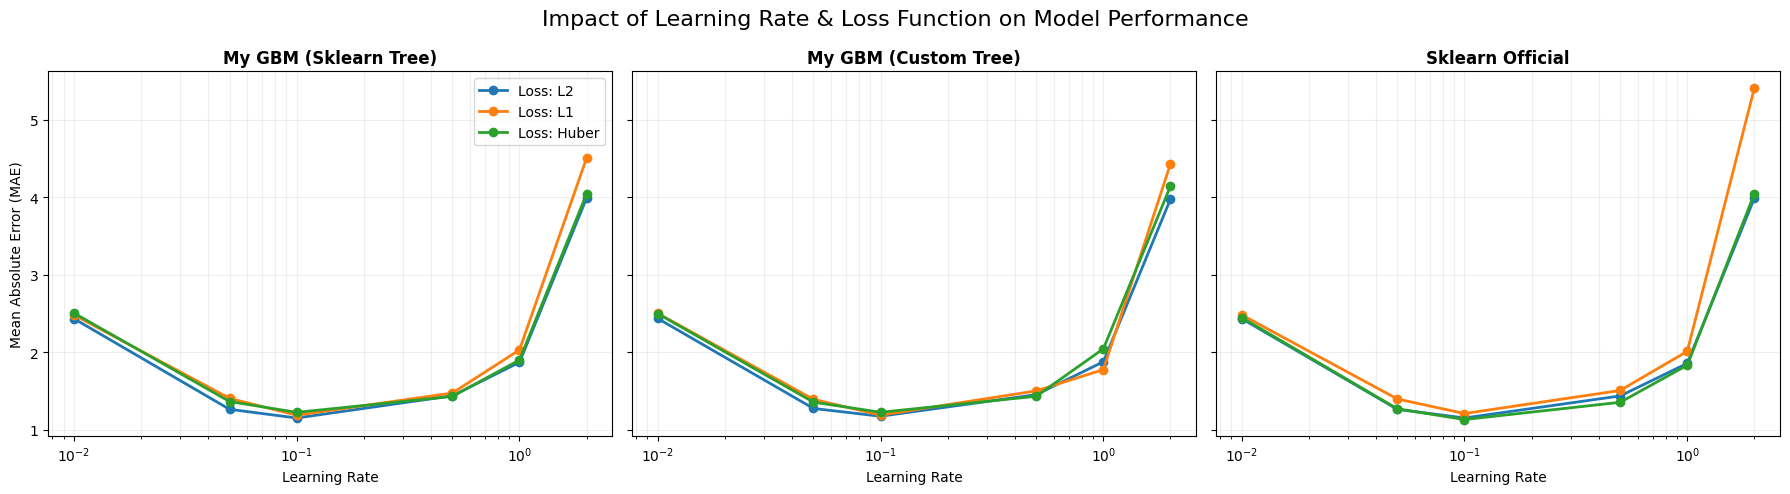

In [13]:
from sklearn.metrics import mean_absolute_error

# Setup Data Storage
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]

history = {
    "My GBM (Sklearn Tree)": {"L2": [], "L1": [], "Huber": []},
    "My GBM (Custom Tree)":  {"L2": [], "L1": [], "Huber": []},
    "Sklearn Official":      {"L2": [], "L1": [], "Huber": []}
}

print("Starting Learning Rate vs. Loss Analysis...")

for lr in learning_rates:
    print(f"Processing Learning Rate: {lr}...")
    
    # My GBM with Sklearn Tree
    dict_my_gbm = {
        "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, max_depth=3, learning_rate=lr),
        "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, max_depth=3, learning_rate=lr),
        "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, max_depth=3, learning_rate=lr)
    }

    # My GBM with Custom Tree
    dict_custom = {
        "L2": GBRegressor(loss_type=LossType.L2, n_estimators=100, max_depth=3, learning_rate=lr, decision_stump_type=MyDecisionTree),
        "L1": GBRegressor(loss_type=LossType.L1, n_estimators=100, max_depth=3, learning_rate=lr, decision_stump_type=MyDecisionTree),
        "Huber": GBRegressor(loss_type=LossType.HUBER, delta=1.0, n_estimators=100, max_depth=3, learning_rate=lr, decision_stump_type=MyDecisionTree)
    }

    # Sklearn GBM
    dict_sklearn = {
        "L2": GradientBoostingRegressor(loss='squared_error', n_estimators=100, max_depth=3, learning_rate=lr),
        "L1": GradientBoostingRegressor(loss='absolute_error', n_estimators=100, max_depth=3, learning_rate=lr),
        "Huber": GradientBoostingRegressor(loss='huber', alpha=0.9, n_estimators=100, max_depth=3, learning_rate=lr)
    }


    process_models(dict_my_gbm, "My GBM", X_train, X_test, y_train, y_test, history)
    process_models(dict_custom, "My GBM", X_train, X_test, y_train, y_test, history)
    process_models(dict_sklearn, "Sklearn Official", X_train, X_test, y_train, y_test, history)


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

implementation_names = [
    "My GBM", 
    "My GBM", 
    "Sklearn Official"
]

for idx, impl_name in enumerate(implementation_names):
    ax = axes[idx]
    
    # Retrieve data for this implementation
    data = history[impl_name]
    
    # Plot line for each loss type
    for loss_name, errors in data.items():
        ax.plot(learning_rates, errors, marker='o', linewidth=2, label=f"Loss: {loss_name}")
    
    ax.set_title(impl_name, fontsize=12, fontweight='bold')
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log') # Log scale is better for [0.01, ..., 1.0]
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    # Only add legend to the first plot to avoid clutter
    if idx == 0:
        ax.set_ylabel("Mean Absolute Error (MAE)")
        ax.legend()

plt.suptitle("Impact of Learning Rate & Loss Function on Model Performance", fontsize=16)
plt.tight_layout()
plt.savefig("figs/experiment5/learning_rate_comparison.png")
plt.show()

The results demonstrate that the learning rate is a powerful tool, with moderate values consistently providing the best balance of speed and precision. At a high learning rate, you likely observed that the MAE drops quickly or even begins to fluctuate, as the model takes steps that are too aggressive, leading to overfitting of the training residuals. On the other hand, a low learning rate results in a very slow reduction of error, indicating that 100 estimators were likely insufficient for the model to fully converge. This experiment highlights that for optimal results, the learning rate and the number of estimators must be tuned together: a smaller learning rate generally requires a larger number of trees to reach the same level of performance.

### Experiment 6

The goal of this final experiment is to investigate the influence of the Huber threshold ($\delta$) on the model's predictive performance.

We will use the same data set as the experiment 4.

    Model initialization


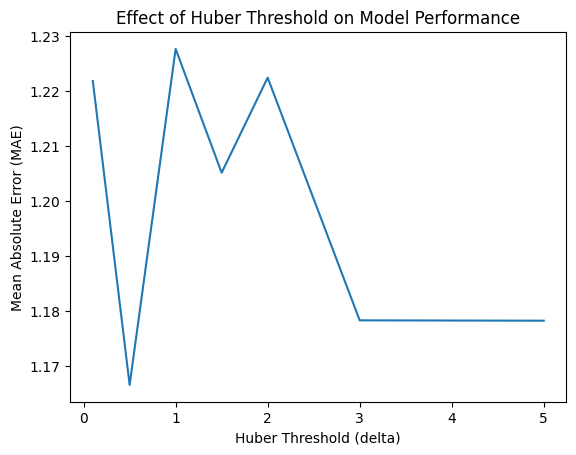

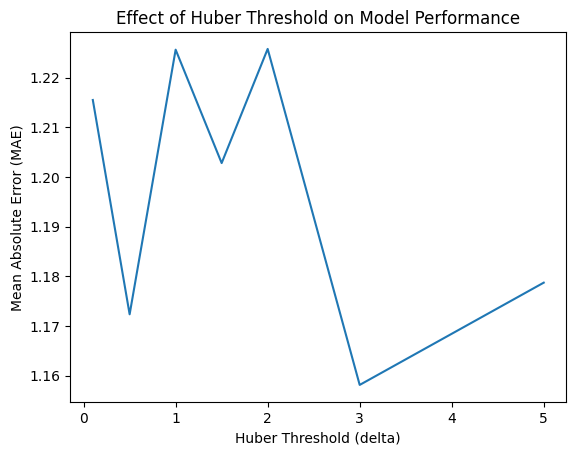

In [14]:
deltas = [0.1, 0.5, 1.0, 1.5, 2.0, 3.0, 5.0]
errors = []

for d in deltas:
    model = GBRegressor(loss_type=LossType.HUBER, delta=d, n_estimators=100, max_depth=3, decision_stump_type=MyDecisionTree)
    model.fit(X_train, y_train)
    errors.append(mean_absolute_error(y_test, model.predict(X_test)))

plt.plot(deltas, errors)
plt.xlabel("Huber Threshold (delta)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Effect of Huber Threshold on Model Performance")
plt.savefig("figs/experiment6/huber_threshold_vs_mae_custom_tree.png")
plt.show()

errors = []


for d in deltas:
    model = GBRegressor(loss_type=LossType.HUBER, delta=d, n_estimators=100, max_depth=3)
    model.fit(X_train, y_train)
    errors.append(mean_absolute_error(y_test, model.predict(X_test)))

plt.plot(deltas, errors)
plt.xlabel("Huber Threshold (delta)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Effect of Huber Threshold on Model Performance")
plt.savefig("figs/experiment6/huber_threshold_vs_mae_default_tree.png")
plt.show()

The results show that the Mean Absolute Error (MAE) is highly sensitive to the choice of $\delta$. When $\delta$ is very small, the model behaves almost exactly like L1, which might be too robust and ignore useful variations in the data. When $\delta$ is very large, the model effectively becomes an L2 regressor, losing its robustness to outliers.

### Experiment 7
The goal of this experiment is to visualize the learning trajectory of the Gradient Boosting ensemble to diagnose the bias-variance trade-off. By monitoring the training and testing error simultaneously as each new tree is added, we can observe how the model gradually moves from a state of high bias  toward an optimal fit.

We will use the same data set as the experiment 4.

    Model initialization


Training model with L2 loss...
Training model with L1 loss...
Training model with Huber loss...


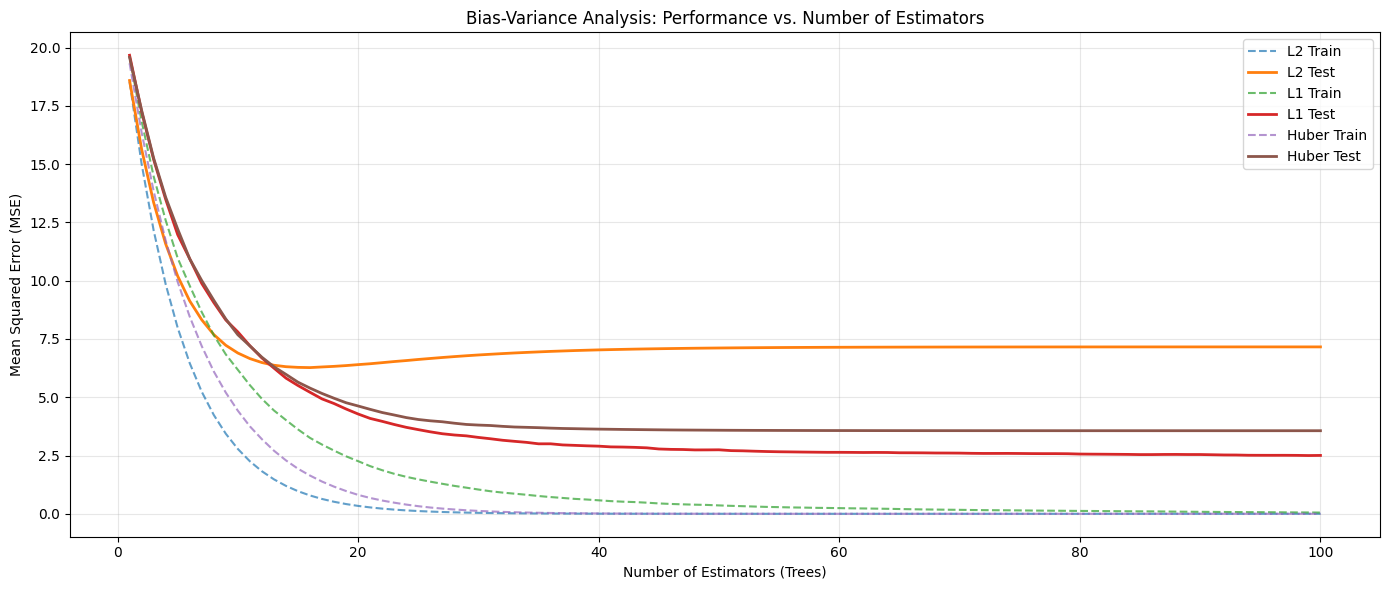

In [15]:
n_estimators = 100
learning_rate = 0.1

loss_scenarios = [
    (LossType.L2, "L2"),
    (LossType.L1, "L1"),
    (LossType.HUBER, "Huber")
]

plt.figure(figsize=(14, 6))

for loss_type, label in loss_scenarios:
    print(f"Training model with {label} loss...")
    model = GBRegressor(n_estimators=100, 
                        learning_rate=learning_rate,
                        loss_type=loss_type, delta=1.0)
    model.fit(X_train, y_train)
    
    # Initialize predictions with the constant "F0"
    train_pred = np.full(y_train.shape, model.initial_prediction_)
    test_pred = np.full(y_test.shape, model.initial_prediction_)
    
    train_errors = []
    test_errors = []
    
    estimators = getattr(model, 'estimators_', getattr(model, 'estmiators_', []))
    
    for i, estimator in enumerate(estimators):
      
        train_pred += learning_rate * estimator.predict(X_train)
        test_pred += learning_rate * estimator.predict(X_test)
        
        # Calculate errors at this stage
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        
        train_errors.append(train_mse)
        test_errors.append(test_mse)
        
    steps = range(1, len(train_errors) + 1)
    plt.plot(steps, train_errors, linestyle='--', alpha=0.7, label=f'{label} Train')
    plt.plot(steps, test_errors, linestyle='-', linewidth=2, label=f'{label} Test')


plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Bias-Variance Analysis: Performance vs. Number of Estimators')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig("figs/experiment7/bias_variance_analysis.png")
plt.show()

Across all loss types, you will see the training error continue to decline monotonically as the model becomes increasingly complex. The Test Error, however, provides the most critical insight: if the test curve flattens out or begins to rise while the training curve continues to drop, it signals that the variance is increasing. 

This experiment confirms that using a loss like Huber can often lead to a more stable test error curve compared to L2, especially in the presence of the noise introduced in the Friedman dataset.